In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from AI.Features.Segmenting import deep_segment
#from AI.Features.SegmentingV2 import deep_segment
#from AI.Features.SegmentingV8 import deep_segment

from AI.Features.Segmenting import restore_mask
#from AI.Features.SegmentingV8 import restore_mask

from skimage import measure
import glob
import pandas as pd 

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn import metrics
from sklearn.metrics import accuracy_score,f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from skimage import feature
import os

In [2]:
## Augmentation Function

from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
def augm(lst, nm=5):
    # prepare iterator
    ls_gen=[]
    for arr in lst:

        data = arr
        # expand dimension to one sample
        samples = expand_dims(data, 0)
        # create image data augmentation generator
        datagen = ImageDataGenerator(zoom_range=[0.5,1.0],
                                     brightness_range=[0.8,1],
                                     #rotation_range=50,
                                     width_shift_range=[0,.1],
                                     height_shift_range=[0,.1],
                                    #vertical_flip =True,
                                    #horizontal_flip=True
                                    ) 
        it = datagen.flow(samples, batch_size=1)
        # generate samples and plot

        for i in range(nm):
            # define subplot
            #pyplot.subplot(330 + 1 + i)
            # generate batch of images
            batch = it.next()
            # convert to unsigned integers for viewing
            image = batch[0].astype('uint8')
            ls_gen.append(image)
    return lst+ls_gen

lymph= 5725
neut= 5860
MONO= 409
BASO= 85
EOSI= 596
[5725, 5860, 409, 85, 596]
12675


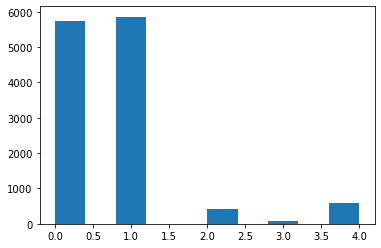

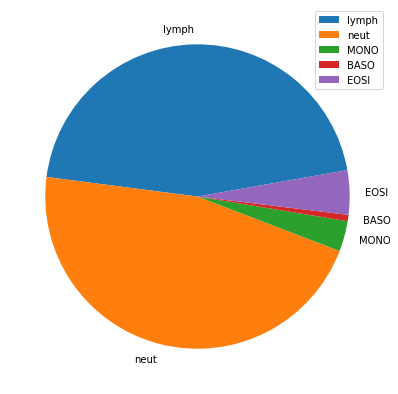

In [3]:
path1='./samples/Experiment/Training/*/*/'    
lymph = [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Lymphocyte/*.png') if os.path.getsize(f)>200]
neut =  [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Neutrophil/*.png') if os.path.getsize(f)>200]
BASO =  [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Basophil/*.png') if os.path.getsize(f)>200]
EOSI =  [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Eosinophil/*.png') if os.path.getsize(f)>200]
MONO =  [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Monocyte/*.png')if os.path.getsize(f)>200]

#MONO=augm(MONO, nm=3)

ln=[len(lymph),len(neut),len(MONO),len(BASO),len(EOSI)]
print('lymph=',len(lymph))
print('neut=',len(neut))
print('MONO=',len(MONO))
print('BASO=',len(BASO))
print('EOSI=',len(EOSI))

print(ln)
print(sum(ln))
ls5=len(lymph)*[0] + len(neut)*[1]+len(MONO)*[2]+len(BASO)*[3]+len(EOSI)*[4]
p=plt.hist(ls5,10)
plt.show()

y = np.array(ln)
mylabels =["lymph","neut","MONO","BASO","EOSI"] 
plt.figure(figsize=(7, 7))
plt.pie(y, labels = mylabels, startangle = 10)
plt.legend()
plt.show()


In [4]:
import numpy as np
from skimage.feature import greycomatrix, greycoprops
from skimage import io, color, img_as_ubyte
def GLCM(c):
    img =c# io.imread('ff.jpg')

    gray = color.rgb2gray(img)
    image = img_as_ubyte(gray)
    #io.imshow(image)

    bins = np.array([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 255]) #16-bit
    inds = np.digitize(image, bins)

    max_value = inds.max()+1
    matrix_coocurrence = greycomatrix(inds, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=max_value, normed=False, symmetric=False)

    # GLCM properties
    def contrast_feature(matrix_coocurrence):
        contrast = greycoprops(matrix_coocurrence, 'contrast')
        return "Contrast = ", contrast

    def dissimilarity_feature(matrix_coocurrence):
        dissimilarity = greycoprops(matrix_coocurrence, 'dissimilarity')    
        return "Dissimilarity = ", dissimilarity

    def homogeneity_feature(matrix_coocurrence):
        homogeneity = greycoprops(matrix_coocurrence, 'homogeneity')
        return "Homogeneity = ", homogeneity

    def energy_feature(matrix_coocurrence):
        energy = greycoprops(matrix_coocurrence, 'energy')
        return "Energy = ", energy

    def correlation_feature(matrix_coocurrence):
        correlation = greycoprops(matrix_coocurrence, 'correlation')
        return "Correlation = ", correlation
   
    def ASM_feature(matrix_coocurrence):
        ASM = greycoprops(matrix_coocurrence, 'ASM')
        return "ASM = ", ASM

    
    f1=contrast_feature(matrix_coocurrence)[1][0].tolist()
    f2=dissimilarity_feature(matrix_coocurrence)[1][0].tolist()
    f3=homogeneity_feature(matrix_coocurrence)[1][0].tolist()
    f4=energy_feature(matrix_coocurrence)[1][0].tolist()
    f5=correlation_feature(matrix_coocurrence)[1][0].tolist()
    f6=ASM_feature(matrix_coocurrence)[1][0].tolist()
    
    
    """
    print(contrast_feature(matrix_coocurrence))
    print(dissimilarity_feature(matrix_coocurrence))
    print(homogeneity_feature(matrix_coocurrence))
    print(energy_feature(matrix_coocurrence))
    print(correlation_feature(matrix_coocurrence))
    print(ASM_feature(matrix_coocurrence))
    ent=measure.shannon_entropy( cv2.cvtColor(lymph[30], cv2.COLOR_BGR2GRAY) )
    print(ent)

    from skimage.morphology import disk, ball
    from skimage.filters import rank
    im2=rank.entropy(gray,disk(3)) 
    plt.imshow(im2,cmap='gray')
    plt.show()
    """
    return  np.array(f1+f2+f3+f4+f5+f6)
    
GLCM(neut[0])

array([0.73417722, 1.3845166 , 0.78876812, 1.31168593, 0.40650995,
       0.58429646, 0.41956522, 0.54191891, 0.82846997, 0.77692356,
       0.8248188 , 0.79351835, 0.39057531, 0.37032605, 0.38929124,
       0.37482908, 0.97457692, 0.95259229, 0.97277209, 0.95507075,
       0.15254907, 0.13714139, 0.15154767, 0.14049684])

In [6]:
import numpy as np
from skimage.transform import integral_image
from skimage.feature import haar_like_feature
img = cv2.cvtColor(lymph[4], cv2.COLOR_BGR2GRAY)  
img_ii = integral_image(img)
feature = haar_like_feature(img_ii, 0, 0, 5, 5, 'type-3-x')
feature

array([-177, -355, -534, -711, -178, -355, -531, -707, -176, -351, -526,
       -700, -178, -357, -534, -711, -177, -353, -529, -704, -175, -350,
       -524, -697, -179, -356, -533, -176, -352, -527, -175, -349, -522,
       -177, -354, -176, -351, -174, -347, -177, -175, -173])

In [7]:
from skimage.feature import shape_index
image = color.rgb2gray(lymph[4])
#image = img_as_ubyte(image)
square =image
s = shape_index(square, sigma=0.1)
np.floor(s*10)[0]

C:\Users\DELL\anaconda3\lib\site-packages\skimage\feature\corner.py:397: RuntimeWarning: divide by zero encountered in true_divide
  return (2.0 / np.pi) * np.arctan((l2 + l1) / (l2 - l1))
C:\Users\DELL\anaconda3\lib\site-packages\skimage\feature\corner.py:397: RuntimeWarning: invalid value encountered in true_divide
  return (2.0 / np.pi) * np.arctan((l2 + l1) / (l2 - l1))


array([ 1.,  1.,  1., -4., -6., -2., -2., -3., -4., -4., -3., -1.,  0.,
        0., -4., -1.,  2.,  0., -3.,  0.,  2.,  4.,  3.,  6.,  2.,  4.,
        3.,  2.,  2.,  2., -1., -3., -3., -2., -1., -1., -4., -1., -2.,
       -1., -1., -1., -2., -3., -5., -8.,  1.,  5.,  4.,  2.,  2.,  3.,
        3.,  1., -3.,  0.,  1., -2., -3., -5., -5., -4.,  2.,  3.,  3.])

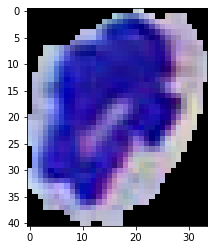

In [8]:
def get_nuc_and_cyt(segmented):
    nuc = (segmented==2).astype('uint8')
    cyt = (segmented==1).astype('uint8')
    #cyt,nuc=restore_mask(segmented)
    return cyt,nuc
     
def mask_cell(img):
    im_mask=deep_segment(img)
    #print(im_mask.sum())
    #if im_mask.sum()<1000:
    #    print("No Cell detected")
    #    return img
    cyt,nuc= get_nuc_and_cyt(im_mask)
    if nuc.sum()!=0:
        #reg=measure.regionprops(cyt)
        tb=measure.regionprops(cyt)[0]['bbox']
    else:
        print("No cell detected...........")
        tb=(0,0,img.shape[0]-1,img.shape[1]-1)
    #img=cv2.blur(img,(3,3))                #++
    #img=cv2.medianBlur(img,15)
     
    im=img.copy()
    rows=im_mask.shape[0]
    columns=im_mask.shape[1]
    for i in range(rows):
        for j in range(columns):
            if im_mask[i,j]==0:
                im[i,j,:]=0
    im=im[tb[0]:tb[2],tb[1]:tb[3]]  #to crop it around box
    #im=cv2.resize(im,(100,100))
    return im

img=mask_cell(neut[15])
plt.imshow(img)
plt.show()

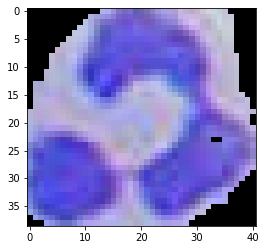

In [182]:
def mask_cell_nec(img):
    im_mask=deep_segment(img)
    #print(im_mask.sum())
    #if im_mask.sum()<1000:
    #    print("No Cell detected")
    #    return img
    cyt,nuc= get_nuc_and_cyt(im_mask)
    if nuc.sum()!=0:
        #reg=measure.regionprops(cyt)
        tb=measure.regionprops(nuc)[0]['bbox']
    else:
        print("No cell detected...........")
        tb=(0,0,img.shape[0]-1,img.shape[1]-1)
    #img=cv2.blur(img,(3,3))                #++
    #img=cv2.medianBlur(img,15)
     
    im=img.copy()
    rows=im_mask.shape[0]
    columns=im_mask.shape[1]
    for i in range(rows):
        for j in range(columns):
            if im_mask[i,j]==0:
                im[i,j,:]=0
    im=im[tb[0]:tb[2],tb[1]:tb[3]]  #to crop it around box
    #im=cv2.resize(im,(100,100))
    return im

img=mask_cell_nec(neut[15])
plt.imshow(img)
plt.show()

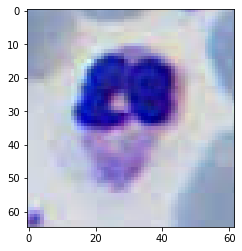

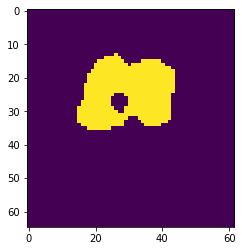

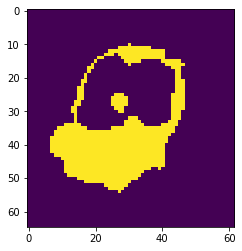

In [9]:
img3=neut[10]
mas=deep_segment(img3)
#nuc2, cyt2=restore_mask(mas)
cyt2, nuc2=get_nuc_and_cyt(mas)
plt.imshow(img3)
plt.show()
plt.imshow(nuc2)
plt.show()
plt.imshow(cyt2)
plt.show()

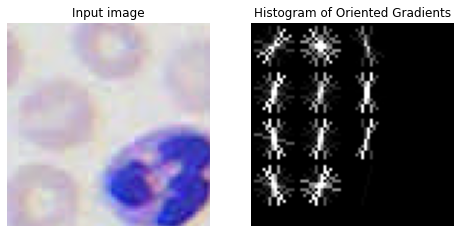

128

In [10]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure

def HOG_im(c):
    image = mask_cell(c)
    #plt.imshow(image)
    #plt.show()
    #image=c
    image=cv2.resize(image,(70,70))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                        cells_per_block=(1, 1), visualize=True,feature_vector=True)

    
    return fd,hog_image

ind=1541
image=neut[ind]
fd,hog_image=HOG_im(image)

#image=mask_cell(image)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()
len(fd)
len(fd)
 

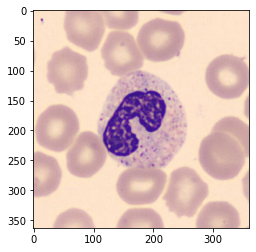

NameError: name 'lst1' is not defined

In [11]:


pbc =  [cv2.imread(f)[:,:,::-1] for f in glob.glob('./samples/PBC/NEUT/*.jpg')]
plt.imshow(pbc[10])
plt.show()

d1 = [data1[i] for i,c in enumerate(lst1) if c==1] #+neut
plt.imshow(d1[10])
plt.show()

d2 = [data2[i] for i,c in enumerate(lst2) if c==1] #+neut
plt.imshow(d2[20])
plt.show()

# Extent feature

In [12]:

def get_extent(nuc, cyt):
    
    # We only use the nucleus
    extent = measure.regionprops(nuc)[0]['extent']
    
    return extent

def all_together(cell):
    segmented = deep_segment(cell)
    cyt,nuc = get_nuc_and_cyt(segmented)
    extent = get_extent(nuc,cyt)
    return extent

In [13]:
#'eccentricity', 'solidity', 'extent', 'circularity', 'nuc_cyto_ratio', 'size', 'tortuosity'
from skimage import morphology

def eccentricity(im_part):
    if im_part.sum()!=0:
        #reg=measure.regionprops(cyt)
        tb=measure.regionprops(im_part)[0]['bbox']
    else:
        print("No cell detected...........")
        tb=(0,0,im_part.shape[0]-1,im_part.shape[1]-1)
    
    #tb=measure.regionprops(im_part)[0]['bbox']
    
    xb=abs(tb[1]-tb[3])
    xs=abs(tb[0]-tb[2])
    if xs>xb:
        tm=xb
        xb=xs
        xs=tm
    return np.sqrt(xb**2-xs**2)/xs
    
def Solidity(im_part):
    conv=morphology.convex_hull.convex_hull_image(im_part)  
    """
    print(im_part.sum())
    print(conv.sum())
    plt.imshow(im_part)
    plt.show()
    plt.imshow(conv)
    plt.show()
    """ 
    return im_part.sum()/conv.sum()

def circularity(im_part):
    pr=measure.perimeter(im_part, neighbourhood=8)
    return (pr**2)/(4*np.pi*im_part.sum())

def Convexity(im_part):
    conv=morphology.convex_hull.convex_hull_image(im_part)  
    return measure.perimeter(conv)/measure.perimeter(im_part)

In [14]:
img=neut[13]
segmented = deep_segment(img)
cyt,nuc = get_nuc_and_cyt(segmented)
print(eccentricity(nuc),eccentricity(nuc+cyt))
print(Solidity(nuc),Solidity(nuc+cyt))
print(circularity(nuc),circularity(nuc+cyt))
print(Convexity(nuc),Convexity(nuc+cyt))

0.5532833351724882 0.5604451362476125
0.8317107093184979 0.8827067669172932
3.322026755306083 2.832332396017907
0.7422372006734098 0.7905412807368913


In [15]:
def shape_features(image):
    segmented = deep_segment(image)
    cyt,nuc = get_nuc_and_cyt(segmented)
    all_cyt=nuc+cyt
    n_sum=nuc.sum()
    cyt_sum=all_cyt.sum()
    lst=[eccentricity(nuc),eccentricity(all_cyt),Solidity(nuc),Solidity(all_cyt),circularity(nuc),
         circularity(all_cyt),Convexity(nuc),Convexity(all_cyt)]
    lst.append(measure.perimeter(nuc, neighbourhood=8)/n_sum)
    lst.append(measure.perimeter(cyt, neighbourhood=8)/cyt_sum)
    lst.append(n_sum/cyt_sum)
    return np.array(lst)
    
img=neut[12]    
shape_features(img)    

array([0.92173749, 0.61011876, 0.65181518, 0.76022305, 4.24784621,
       3.98583066, 0.77195664, 0.69245105, 0.36761293, 0.28661338,
       0.48288509])

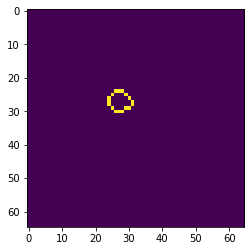

In [16]:
segmented = deep_segment(neut[10])
cyt,nuc = get_nuc_and_cyt(segmented)
eccentricity(cyt)
cyt.sum()
plt.imshow(nuc)
contours, hierarchy = cv2.findContours(nuc,cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)
hull = [cv2.convexHull(cnt) for cnt in contours]

nn=np.zeros((nuc.shape[0],nuc.shape[0]),dtype=int)
for z in contours[0]:
    nn[z[0][0],z[0][1]]=1
plt.imshow(nn)




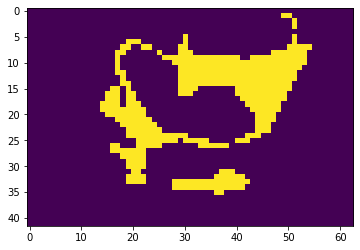

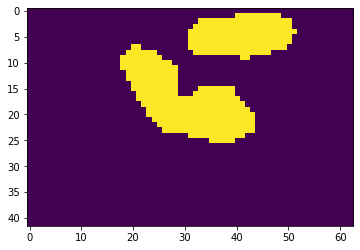

(2251,)
(395,)
2646


2646

In [17]:
segmented = deep_segment(neut[12])
cyt, nuc = get_nuc_and_cyt(segmented)
#print(all_together(MONO[23]))
plt.imshow(cyt)
plt.show()
plt.imshow(nuc)
plt.show()
print(nuc[nuc==0].shape)
print(nuc[nuc==1].shape)
print(nuc[nuc==1].shape[0]+nuc[nuc==0].shape[0])
nuc.shape[0]*nuc.shape[1]

0.4647058823529412


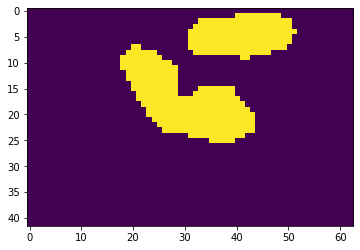

0
(1, 18, 26, 52)


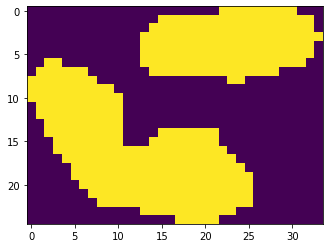

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


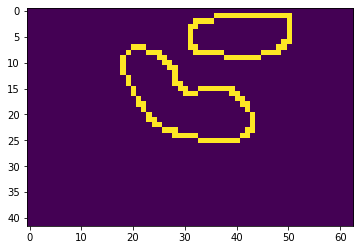

array([ 0, 15,  5,  3,  2,  2,  3,  7, 14, 10,  3,  3,  2,  2,  3, 10,  6,
        3,  4,  2,  2,  3,  3,  5,  7,  8,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0])

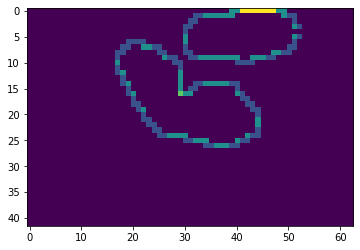

In [18]:

segmented = deep_segment(neut[12])
cyt,nuc = get_nuc_and_cyt(segmented)
print(all_together(neut[12]))
plt.imshow(nuc)
plt.show()
print(nuc.min())
tb=measure.regionprops(nuc)[0]['bbox']
print(tb)
im2=nuc[tb[0]:tb[2],tb[1]:tb[3]]
im2.shape
plt.imshow(im2)
plt.show()


r=nuc.shape[0]
c=nuc.shape[1]

from skimage import feature
edges1 = feature.canny(nuc*255,sigma=2)
print(edges1)
#edges2=cv2.threshold(edges1, 127, 255, cv2.THRESH_BINARY)[1]
plt.imshow(edges1)
plt.show()
e2=cv2.Laplacian(nuc*255, 2, ksize=3)
plt.imshow(e2)
edges1.sum(axis=1)

# LBP Feature Extraction

In [19]:


 
from skimage import feature
import numpy as np
class LocalBinaryPatterns:  
    def __init__(self, numPoints, radius):
        # store the number of points and radius
        self.numPoints = numPoints
        self.radius = radius
    def describe(self, image, eps=1e-7):
        
        # compute the Local Binary Pattern representation
        # of the image, and then use the LBP representation
        # to build the histogram of patterns
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        lbp = feature.local_binary_pattern(image, self.numPoints,
            self.radius, method="uniform")
        (hist, _) = np.histogram(lbp.ravel(),
            bins=np.arange(0, self.numPoints + 3),
            range=(0, self.numPoints + 2))
        # normalize the histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)
        # return the histogram of Local Binary Patterns
        return hist
 

points=24  #24

obj=LocalBinaryPatterns(points,8)

v=obj.describe(mask_cell(neut[7]))
 
v



array([0.05333333, 0.06444444, 0.04388889, 0.02333333, 0.01555556,
       0.00611111, 0.00944444, 0.01      , 0.00555556, 0.00277778,
       0.00055556, 0.00333333, 0.00222222, 0.00277778, 0.00333333,
       0.        , 0.00722222, 0.00388889, 0.00388889, 0.00166667,
       0.00166667, 0.00555556, 0.00944444, 0.01722222, 0.28388889,
       0.41888889])

#### Sum Of Edges (SOE)

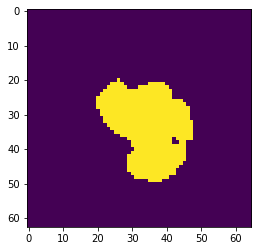

[2 4 4 2 2 1 1 1 1 2 2 2 2 2 2 2 2 4 4 2 2 2 2 2 2 2 2 2 2 2]


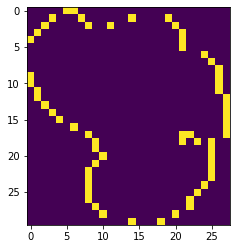

array([0.  , 0.5 , 0.  , 0.08, 0.  ])

In [20]:
def edges1(im):
    for i in range(im.shape[0]-1):
        for j in range(im.shape[1]-1):
            if im[i,j]==0 and im[i,j+1]==1:
                im[i,j]=1
            elif im[i,j]==1 and im[i,j+1]==0:
                im[i,j]=1
            else:
                im[i,j]=0
    return im

def count_list(ls):
    ls2=[0,0,0,0,0]
    for x in ls:
        if x==1:
            ls2[0]=ls2[0]+1
        elif x==2:
            ls2[1]=ls2[1]+1
        elif x==3:
            ls2[2]=ls2[2]+1
        elif x==4:
            ls2[3]=ls2[3]+1
        elif x>4:
            ls2[4]=ls2[4]+1
    return ls2
        
def SOE(c):
    segmented = deep_segment(c)  
    cyt,nuc = get_nuc_and_cyt(segmented)
    
    if nuc.sum()!=0:
        tb=measure.regionprops(nuc)[0]['bbox']
    else:
        print("No cell detected...........")
        tb=(0,0,nuc.shape[0]-1,nuc.shape[1]-1)
    
    
    
    #tb=measure.regionprops(nuc)[0]['bbox']
    
    xv=abs(tb[1]-tb[3])
    xh=abs(tb[0]-tb[2])
    
    im=nuc.copy()
    im2=edges1(im)
    im=nuc.copy()
    im3=edges1(im.T)

    v2=im2.sum(axis=1)
    v3=im3.sum(axis=1)
    im_ls=v2.tolist()+v3.tolist()
    #cn=(xh+xv)/2
    freq=np.array(count_list(im_ls))
    return freq/100  #np.array([freq[3]/freq[1]]) #np.array([ freq[2]/freq[1],freq[3]/freq[1],freq[4]/freq[1] ])    #/100#cn #(len(v2)+len(v3))

#### Examples##################
ind=60
mmg=neut[ind]
segmented = deep_segment(mmg)  
cyt,nuc  = get_nuc_and_cyt(segmented)
plt.imshow(nuc)
plt.show()
tb=measure.regionprops(nuc)[0]['bbox']

imt=edges1(nuc)
imt=imt[tb[0]:tb[2],tb[1]:tb[3]] 
print(imt.sum(axis=1))
plt.imshow(imt)
plt.show()

SOE(mmg)  #np.divide

# LBP and Extent

In [21]:
obj=LocalBinaryPatterns(points,8)   #(58,4)
def LBP_and_extent(c):

    ss=obj.describe(mask_cell(c))
    ss=ss.tolist()
    ss.append(all_together(c)/10)
    ss=np.array(ss)
    return ss
LBP_and_extent(lymph[-4])

array([5.56586271e-02, 3.29313544e-02, 1.71614100e-02, 8.81261596e-03,
       1.85528757e-03, 4.63821892e-04, 4.63821892e-04, 0.00000000e+00,
       0.00000000e+00, 1.39146568e-03, 9.27643785e-04, 2.31910946e-03,
       2.31910946e-03, 4.63821892e-03, 6.02968460e-03, 3.24675325e-03,
       2.31910946e-03, 4.63821892e-03, 9.27643785e-04, 2.78293135e-03,
       1.39146568e-03, 2.31910946e-03, 2.78293135e-03, 1.29870130e-02,
       4.95361781e-01, 3.36270872e-01, 7.12631579e-02])

In [22]:
obj=LocalBinaryPatterns(points,8)   #(58,4)
def SOE_LBP_and_extent(c):
    ss=obj.describe(mask_cell(c))
    ss=ss.tolist()
    s2=SOE(c)
    s2=s2.tolist()
    ss=ss+s2
    ss.append(all_together(c)/10)
    ss=np.array(ss)
    return ss
SOE_LBP_and_extent(neut[7])

array([0.05333333, 0.06444444, 0.04388889, 0.02333333, 0.01555556,
       0.00611111, 0.00944444, 0.01      , 0.00555556, 0.00277778,
       0.00055556, 0.00333333, 0.00222222, 0.00277778, 0.00333333,
       0.        , 0.00722222, 0.00388889, 0.00388889, 0.00166667,
       0.00166667, 0.00555556, 0.00944444, 0.01722222, 0.28388889,
       0.41888889, 0.        , 0.41      , 0.        , 0.19      ,
       0.01      , 0.05580645])

### SOE+Extent 

In [23]:
obj=LocalBinaryPatterns(points,8)   #(58,4)
def SOE_and_extent(c):

    ss=SOE(c)
    ss=ss.tolist()
    ss.append(all_together(c)/10)
    ss=np.array(ss)
    return ss
SOE_and_extent(lymph[4])

array([0.        , 0.62      , 0.        , 0.        , 0.        ,
       0.07450366])

### Shape Features+ SOE

In [24]:

def shapef_and_SOE(c):

    ss=SOE(c)
    ss=ss.tolist()
    s2=shape_features(c)
    s2=s2.tolist()
    ss=ss+s2
    ss=np.array(ss)
    return ss
shapef_and_SOE(lymph[-4])

array([0.        , 0.63      , 0.        , 0.        , 0.        ,
       1.14472704, 0.4900877 , 0.95892351, 0.7605245 , 1.74952893,
       1.87662246, 1.        , 1.11338967, 0.18020679, 0.19475619,
       0.61433757])

### Shape Features+ SOE+Extent

In [25]:
def shapef_and_SOE_extent(c):

    ss=SOE(c)
    ss=ss.tolist()
    s2=shape_features(c)
    s2=s2.tolist()
    ss=ss+s2
    ss.append(all_together(c)/10)
    ss=np.array(ss)
    return ss
shapef_and_SOE_extent(lymph[-4])

array([0.        , 0.63      , 0.        , 0.        , 0.        ,
       1.14472704, 0.4900877 , 0.95892351, 0.7605245 , 1.74952893,
       1.87662246, 1.        , 1.11338967, 0.18020679, 0.19475619,
       0.61433757, 0.07126316])

### Shape Features+ SOE+Extent+LBP

In [26]:
def shapef_and_SOE_extent_LBP(c):

    ss=SOE(c)
    ss=ss.tolist()
    s2=shape_features(c)
    s2=s2.tolist()
    s3=obj.describe(mask_cell(c))
    s3=s3.tolist()
    ss=ss+s2+s3
    ss.append(all_together(c)/10)
    ss=np.array(ss)
    return ss
shapef_and_SOE_extent_LBP(lymph[-4])

array([0.00000000e+00, 6.30000000e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.14472704e+00, 4.90087697e-01, 9.58923513e-01,
       7.60524500e-01, 1.74952893e+00, 1.87662246e+00, 1.00000000e+00,
       1.11338967e+00, 1.80206795e-01, 1.94756189e-01, 6.14337568e-01,
       5.56586271e-02, 3.29313544e-02, 1.71614100e-02, 8.81261596e-03,
       1.85528757e-03, 4.63821892e-04, 4.63821892e-04, 0.00000000e+00,
       0.00000000e+00, 1.39146568e-03, 9.27643785e-04, 2.31910946e-03,
       2.31910946e-03, 4.63821892e-03, 6.02968460e-03, 3.24675325e-03,
       2.31910946e-03, 4.63821892e-03, 9.27643785e-04, 2.78293135e-03,
       1.39146568e-03, 2.31910946e-03, 2.78293135e-03, 1.29870130e-02,
       4.95361781e-01, 3.36270872e-01, 7.12631579e-02])

In [27]:
def shapef_extent(c):

    ss=shape_features(c)
    ss=ss.tolist()
    ss.append(all_together(c)/10)
    ss=np.array(ss)
    return ss
shapef_extent(lymph[-4])

array([1.14472704, 0.4900877 , 0.95892351, 0.7605245 , 1.74952893,
       1.87662246, 1.        , 1.11338967, 0.18020679, 0.19475619,
       0.61433757, 0.07126316])

In [28]:
import tensorflow as tf
import tensorflow_hub as hub

import tensorflow_datasets as tfds

import time

from PIL import Image
import requests
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np

import os
import pathlib

import cv2

# Load model into KerasLayer
#model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
#model_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2" #.99
#model_url = "https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/5"          #97
model_url = ".\imagenet_efficientnet_v2_imagenet21k_s_feature_vector_2"
module = hub.KerasLayer(model_url)

"""
module = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2",
                   trainable=False),  # Can be True, see below.
    #tf.keras.layers.Dense(num_classes, activation='softmax')
])
module.build([None, 384, 384, 3])  # Batch input shape.
"""

'\nmodule = tf.keras.Sequential([\n    hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2",\n                   trainable=False),  # Can be True, see below.\n    #tf.keras.layers.Dense(num_classes, activation=\'softmax\')\n])\nmodule.build([None, 384, 384, 3])  # Batch input shape.\n'

In [29]:
def deepfeature(image):
    image = np.array(image)
    if len(image.shape)==2:
        backtorgb = cv2.cvtColor(np.array(image, dtype=np.uint8),cv2.COLOR_GRAY2RGB)
        image=backtorgb
        """
        image2=np.zeros((image.shape[0], image.shape[1],3),np.int32)
        image2[:,:,0]=image[:,:]
        image2[:,:,1]=image[:,:]
        image2[:,:,2]=image[:,:]
        image=image2
        """
    image=cv2.resize(image,(384,384))
    # reshape into shape [batch_size, height, width, num_channels]
    img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    image = tf.image.convert_image_dtype(img_reshaped, tf.float32)
    logits=module(image)
    return np.array(logits)[0]
 
image=lymph[10]
logits =deepfeature(image) # module(preprocess_image(image))
logits.shape
 

(1280,)

In [30]:
def shapef_GLCM(c):

    ss=shape_features(c)
    ss=ss.tolist()
    s2=GLCM(mask_cell(c))
    s2=s2.tolist()
    ss=ss+s2
    ss=np.array(ss)
    return ss
shapef_GLCM(lymph[-4])




array([1.14472704, 0.4900877 , 0.95892351, 0.7605245 , 1.74952893,
       1.87662246, 1.        , 1.11338967, 0.18020679, 0.19475619,
       0.61433757, 3.25676317, 5.30571705, 4.79024621, 5.47819767,
       0.51732321, 0.82994186, 0.7438447 , 0.86579457, 0.86836505,
       0.80644909, 0.82135938, 0.79547195, 0.49897692, 0.47493126,
       0.48655677, 0.474017  , 0.85920618, 0.77098653, 0.79426934,
       0.76354328, 0.24897797, 0.22555971, 0.23673749, 0.22469212])

In [31]:
def shapef_GLCM_SOE(c):

    ss=shape_features(c)
    ss=ss.tolist()
    s2=GLCM(mask_cell(c))
    s2=s2.tolist()
    s3=SOE(c)
    s3=s3.tolist()
    ss=ss+s2+s3
    ss=np.array(ss)
    return ss
shapef_GLCM_SOE(lymph[-4])




array([1.14472704, 0.4900877 , 0.95892351, 0.7605245 , 1.74952893,
       1.87662246, 1.        , 1.11338967, 0.18020679, 0.19475619,
       0.61433757, 3.25676317, 5.30571705, 4.79024621, 5.47819767,
       0.51732321, 0.82994186, 0.7438447 , 0.86579457, 0.86836505,
       0.80644909, 0.82135938, 0.79547195, 0.49897692, 0.47493126,
       0.48655677, 0.474017  , 0.85920618, 0.77098653, 0.79426934,
       0.76354328, 0.24897797, 0.22555971, 0.23673749, 0.22469212,
       0.        , 0.63      , 0.        , 0.        , 0.        ])

In [32]:
def shapef_GLCM_SOE_deep(c):

    ss=shape_features(c)
    ss=ss.tolist()
    s2=GLCM(mask_cell(c))
    s2=s2.tolist()
    s3=SOE(c)
    s3=s3.tolist()
    s4=deepfeature(c)
    s4=s4.tolist()
    ss=ss+s2+s3+s4
    ss=np.array(ss)
    return ss
shapef_GLCM_SOE_deep(lymph[-118])

array([ 0.46647411,  0.        ,  0.95577746, ..., -0.1448129 ,
       -0.10549405, -0.03563274])

In [33]:
def shapef_GLCM_SOE_HOG(c):

    ss=shape_features(c)
    ss=ss.tolist()
    s2=GLCM(mask_cell(c))
    s2=s2.tolist()
    s3=SOE(c)
    s3=s3.tolist()
    s4=HOG_im(c)[0]
    s4=s4.tolist()
    ss=ss+s2+s3+s4
    ss=np.array(ss)
    return ss
shapef_GLCM_SOE_HOG(lymph[-4])

array([1.14472704e+00, 4.90087697e-01, 9.58923513e-01, 7.60524500e-01,
       1.74952893e+00, 1.87662246e+00, 1.00000000e+00, 1.11338967e+00,
       1.80206795e-01, 1.94756189e-01, 6.14337568e-01, 3.25676317e+00,
       5.30571705e+00, 4.79024621e+00, 5.47819767e+00, 5.17323208e-01,
       8.29941860e-01, 7.43844697e-01, 8.65794574e-01, 8.68365049e-01,
       8.06449087e-01, 8.21359384e-01, 7.95471954e-01, 4.98976923e-01,
       4.74931264e-01, 4.86556772e-01, 4.74017004e-01, 8.59206179e-01,
       7.70986535e-01, 7.94269336e-01, 7.63543279e-01, 2.48977970e-01,
       2.25559706e-01, 2.36737492e-01, 2.24692120e-01, 0.00000000e+00,
       6.30000000e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.85877235e-01, 0.00000000e+00, 4.16585513e-01, 4.85877235e-01,
       4.85877235e-01, 0.00000000e+00, 3.43840730e-01, 0.00000000e+00,
      

In [34]:
def shapef_GLCM_SOE_HOG_deep(c):

    ss=shape_features(c)
    ss=ss.tolist()
    s2=GLCM(mask_cell(c))
    s2=s2.tolist()
    s3=SOE(c)
    s3=s3.tolist()
    s4=HOG_im(c)[0]
    s4=s4.tolist()
    s5=deepfeature(c)
    #print(len(s4))
    s5=s5.tolist()
    ss=ss+s2+s3+s4+s5
    ss=np.array(ss)
    return ss
shapef_GLCM_SOE_HOG_deep(lymph[1])

array([ 0.38465463,  0.64043442,  0.89252336, ..., -0.16807126,
        0.31207824, -0.00519559])

In [183]:
#obj=LocalBinaryPatterns(points,8)

def features(c, f):
    if f==1:
        return all_together(c) 
    elif f==2:
        return obj.describe(mask_cell(c))
    elif f==3:
        return LBP_and_extent(c)
    elif f==4:
        return vggface3(c)
    elif f==5:
        return SOE_and_extent(c)
    elif f==6:
        return SOE_LBP_and_extent(c)
    elif f==7:
        return deepfeature(mask_cell_nec(c))#mask_cell(c))
    elif f==8:
        return SOE(c)
    elif f==9:
        return shape_features(c)
    elif f==10:
        return shapef_and_SOE(c)    
    elif f==11:
        return shapef_and_SOE_extent(c)    
    elif f==12:
        return shapef_and_SOE_extent_LBP(c)  
    elif f==13:
        return shapef_extent(c)  
    elif f==14:
        return GLCM(mask_cell(c))
    elif f==15:
        return shapef_GLCM(c)
    elif f==16:
        return shapef_GLCM_SOE(c)  
    elif f==17:
        return HOG_im(c)[0]    
    elif f==18:
        return shapef_GLCM_SOE_HOG(c)
    elif f==19:
        #PCA
        c=cv2.resize(mask_cell(c),(100,100))
        return c.reshape(-1)  
    
    elif f==20:
        #lda
        c=cv2.resize(mask_cell(c),(100,100))
        return c.reshape(-1)
    elif f==21:
        return shapef_GLCM_SOE_HOG_deep(c)
    elif f==22:
        return shapef_GLCM_SOE_deep(c)   

In [36]:

def alldata(cls,ft):

    if cls==2:
        lymph_extent = [ features(c, ft) for c in lymph]
        neut_extent = [features(c, ft) for c in neut]
        x = np.array(lymph_extent + neut_extent)#
        if ft==1: x=x.reshape(-1, 1)
        y = len(lymph_extent)*[0] + len(neut_extent)*[1]

    
    elif cls==3:
        neut_extent = [features(c, ft) for c in neut]
        lymph_extent = [features(c, ft) for c in lymph]
        MONO_extent = [ features(c, ft)  for c  in MONO]
        x = np.array(lymph_extent + neut_extent+ MONO_extent)#.reshape(-1, 1)
        if ft==1: x=x.reshape(-1, 1)
        y = len(lymph_extent)*[0] + len(neut_extent)*[1]+len(MONO_extent)*[2]
        
    elif cls==5:
        neut_extent = [features(c, ft)  for c  in neut]
        lymph_extent = [features(c, ft)  for c  in lymph]
        BASO_extent = [ features(c, ft)  for c  in BASO]
        EOSI_extent = [ features(c, ft)  for c in EOSI]
        MONO_extent = [ features(c, ft)  for c  in MONO]
        x = np.array(lymph_extent + neut_extent+ BASO_extent+ EOSI_extent+ MONO_extent)#.reshape(-1, 1)
        if ft==1: x=x.reshape(-1, 1)
        y = len(lymph_extent)*[0] + len(neut_extent)*[1]+len(BASO_extent)*[2]+len(EOSI_extent)*[3]+len(MONO_extent)*[4]
        
    return x,y

In [37]:



def classif(cls,ft):
    print('#########################################################################################')
    print()
    print("classes=",cls,'   Features type=',ft)
    print()
    
    if ft==19:  pca = PCA(n_components=50)
    if ft==20:  lda = LinearDiscriminantAnalysis(n_components=4)
        
    x,y=alldata(cls,ft)
    
    print('training length=',len(x))
    print()
    print('#########################################################################################')    
    names = ["Decision Tree","Nearest Neighbors", "Neural Net", "AdaBoost", "SVM", "GaussianNB",
             "Random Forest"]

    classifiers = [tree.DecisionTreeClassifier(class_weight = 'balanced', max_depth = 1),
                   KNeighborsClassifier(7),
                   MLPClassifier(alpha=.1, max_iter=10000),
                   AdaBoostClassifier(),
                   SVC(gamma=2, C=1),
                   GaussianNB(),
                   RandomForestClassifier(max_depth=1, n_estimators=10, max_features=1)
                   ]
    classifiers=[MLPClassifier(alpha=.1, max_iter=10000)]
    rkf=RepeatedKFold(n_splits=10, n_repeats=1, random_state=0)
    y1=np.array(y)
    for name, clf in zip(names, classifiers):
        list=[]
        list_tr=[]
        for train, test in rkf.split(x):
            #print("%s %s" % (train, test),"\n")
            #print(y1[train])
            X_train, X_test, y_train, y_test=x[train], x[test], y1[train], y1[test]
            
            if ft==19: #PCA
                #X_train = StandardScaler().fit_transform(X_train)
                #X_test = StandardScaler().fit_transform(X_test)
                X_train=pca.fit_transform(X_train)
                X_test= pca.transform(X_test)
                
            if ft==20: #LDA
                #X_train = StandardScaler().fit_transform(X_train)
                #X_test = StandardScaler().fit_transform(X_test)
                X_train=lda.fit_transform(X_train,y_train)
                X_test= lda.transform(X_test)
                
            clf.fit(X_train, y_train)
            predictions=clf.predict(X_test)
            #list.append(accuracy_score(y_test, predictions))
            list.append(f1_score(y_test, predictions,average='micro'))
            
            list_tr.append(accuracy_score(y_train, clf.predict(X_train)))

        print()
        print(name)
        #print(list_tr,"\n")
        print("Training Accuracy",end=" : ")
        print("\t",np.array(list_tr).mean(),"\t\terror +/-=",np.array(list_tr).std())

        #print(list,"\n")
        print("Test Accuracy",end=" : ")
        print("\t",np.array(list).mean(),"\t\terror +/-=",np.array(list).std())

In [ ]:
for cls in [2,3,5]: 
    for ft in [7]:#[1,2,3]:
        classif(cls,ft)

In [ ]:
##########################################################################################

lymph= 5524
neut= 5860
MONO= 409
BASO= 85
EOSI= 596
[5524, 5860, 409, 85, 596]
12474


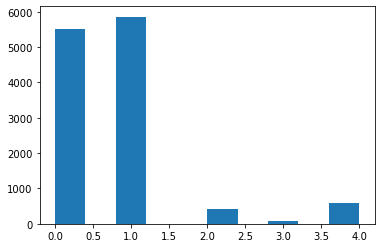

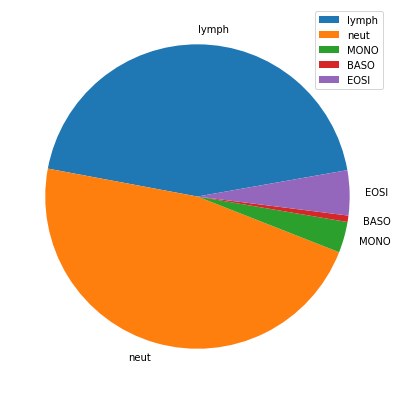

In [184]:
path1='./samples/Experiment/Training/*/*/'    
path2='.\samples\Experiment3\Train\\'
#lymph = [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Lymphocyte/*.png') if os.path.getsize(f)>200]
lymph = [cv2.imread(f)[:,:,::-1] for f in glob.glob(path2+'Lymphocyte/*.png') if os.path.getsize(f)>200]
neut =  [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Neutrophil/*.png') if os.path.getsize(f)>200]
BASO =  [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Basophil/*.png') if os.path.getsize(f)>200]
EOSI =  [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Eosinophil/*.png') if os.path.getsize(f)>200]
MONO =  [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Monocyte/*.png')if os.path.getsize(f)>200]

#MONO=augm(MONO,nm=5)

ln=[len(lymph),len(neut),len(MONO),len(BASO),len(EOSI)]
print('lymph=',len(lymph))
print('neut=',len(neut))
print('MONO=',len(MONO))
print('BASO=',len(BASO))
print('EOSI=',len(EOSI))

print(ln)
print(sum(ln))
ls5=len(lymph)*[0] + len(neut)*[1]+len(MONO)*[2]+len(BASO)*[3]+len(EOSI)*[4]
p=plt.hist(ls5,10)
plt.show()

y = np.array(ln)
mylabels =["lymph","neut","MONO","BASO","EOSI"] 
plt.figure(figsize=(7, 7))
plt.pie(y, labels = mylabels, startangle = 10)
plt.legend()
plt.show()


In [185]:
cl=5
fe=7

x,y=alldata(cl,fe)
X_train=x
y_train=y


No cell detected...........


In [42]:
from sklearn.neural_network import MLPClassifier
mlp =  MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=1000)
mlp.fit(X_train,y_train)


MLPClassifier(hidden_layer_sizes=(8, 8, 8), max_iter=1000)

In [43]:
#mlp.score(X_test,y_test)

NameError: name 'X_test' is not defined

In [186]:
path1='./samples/Experiment/Experiment/*/' 
path2='.\samples\Experiment3\Test/'
lymph = [cv2.imread(f)[:,:,::-1] for f in glob.glob(path2+'Lymphocyte/*.png') if os.path.getsize(f)>200]
neut =  [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Neutrophil/*.png') if os.path.getsize(f)>200]
BASO =  [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Basophil/*.png') if os.path.getsize(f)>200]
EOSI =  [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Eosinophil/*.png') if os.path.getsize(f)>200]
MONO =  [cv2.imread(f)[:,:,::-1] for f in glob.glob(path1+'Monocyte/*.png')if os.path.getsize(f)>200]


ln=[len(lymph),len(neut),len(MONO),len(BASO),len(EOSI)]
"""
print('lymph=',len(lymph))
print('neut=',len(neut))
print('MONO=',len(MONO))
print('BASO=',len(BASO))
print('EOSI=',len(EOSI))

print(ln)
print(sum(ln))
ls5=len(lymph)*[0] + len(neut)*[1]+len(MONO)*[2]+len(BASO)*[3]+len(EOSI)*[4]
 
p=plt.hist(ls5,10)
plt.show()

y = np.array(ln)
mylabels =["lymph","neut","MONO","BASO","EOSI"] 
plt.figure(figsize=(7, 7))
plt.pie(y, labels = mylabels, startangle = 10)
plt.legend()
plt.show()
"""

'\nprint(\'lymph=\',len(lymph))\nprint(\'neut=\',len(neut))\nprint(\'MONO=\',len(MONO))\nprint(\'BASO=\',len(BASO))\nprint(\'EOSI=\',len(EOSI))\n\nprint(ln)\nprint(sum(ln))\nls5=len(lymph)*[0] + len(neut)*[1]+len(MONO)*[2]+len(BASO)*[3]+len(EOSI)*[4]\n \np=plt.hist(ls5,10)\nplt.show()\n\ny = np.array(ln)\nmylabels =["lymph","neut","MONO","BASO","EOSI"] \nplt.figure(figsize=(7, 7))\nplt.pie(y, labels = mylabels, startangle = 10)\nplt.legend()\nplt.show()\n'

In [187]:
#cl=5
#fe=1
x2,y2=alldata(cl,fe)
X_test=x2
y_test=y2

No cell detected...........


In [188]:
dic={0:[1,0,0,0,0],1:[0,1,0,0,0],2:[0,0,1,0,0],3:[0,0,0,1,0],4:[0,0,0,0,1]}
y_train=np.array([dic[x]  for x in y_train] )

dic={0:[1,0,0,0,0],1:[0,1,0,0,0],2:[0,0,1,0,0],3:[0,0,0,1,0],4:[0,0,0,0,1]}
y_test=np.array([dic[x]  for x in y_test] )

In [189]:
class_weight = {0: 1,1: 1,2: 1,3:1, 4:1}

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam

model = Sequential()
model.add(Dense(100, input_dim=X_train.shape[1], activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(100, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(5, activation = 'softmax'))


#sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile('sgd',loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=100, batch_size=16,  validation_data = (X_test, y_test))#class_weight=class_weight)

Epoch 1/100
780/780 [==============================] - 2s 3ms/step - loss: 0.6885 - accuracy: 0.7778 - val_loss: 0.2778 - val_accuracy: 0.9100
Epoch 2/100
780/780 [==============================] - 2s 2ms/step - loss: 0.3808 - accuracy: 0.8802 - val_loss: 0.2619 - val_accuracy: 0.9125
Epoch 3/100
780/780 [==============================] - 2s 2ms/step - loss: 0.3661 - accuracy: 0.8873 - val_loss: 0.2502 - val_accuracy: 0.9195
Epoch 4/100
780/780 [==============================] - 2s 2ms/step - loss: 0.3374 - accuracy: 0.8942 - val_loss: 0.2570 - val_accuracy: 0.9227
Epoch 5/100
780/780 [==============================] - 2s 2ms/step - loss: 0.3207 - accuracy: 0.8973 - val_loss: 0.2385 - val_accuracy: 0.9237
Epoch 6/100
780/780 [==============================] - 2s 2ms/step - loss: 0.3093 - accuracy: 0.9001 - val_loss: 0.2342 - val_accuracy: 0.9236
Epoch 7/100
780/780 [==============================] - 2s 2ms/step - loss: 0.3115 - accuracy: 0.9046 - val_loss: 0.2424 - val_accuracy: 0.9202

Epoch 58/100
780/780 [==============================] - 2s 2ms/step - loss: 0.1992 - accuracy: 0.9399 - val_loss: 0.1987 - val_accuracy: 0.9480
Epoch 59/100
780/780 [==============================] - 2s 2ms/step - loss: 0.1894 - accuracy: 0.9433 - val_loss: 0.1912 - val_accuracy: 0.9508
Epoch 60/100
780/780 [==============================] - 2s 2ms/step - loss: 0.1799 - accuracy: 0.9448 - val_loss: 0.2033 - val_accuracy: 0.9492
Epoch 61/100
780/780 [==============================] - 2s 2ms/step - loss: 0.2007 - accuracy: 0.9383 - val_loss: 0.2065 - val_accuracy: 0.9502
Epoch 62/100
780/780 [==============================] - 2s 2ms/step - loss: 0.1762 - accuracy: 0.9456 - val_loss: 0.1927 - val_accuracy: 0.9541
Epoch 63/100
780/780 [==============================] - 2s 2ms/step - loss: 0.1926 - accuracy: 0.9394 - val_loss: 0.2073 - val_accuracy: 0.9476
Epoch 64/100
780/780 [==============================] - 2s 2ms/step - loss: 0.1936 - accuracy: 0.9422 - val_loss: 0.2226 - val_accuracy:

In [190]:
train_nan=np.isnan(X_train).sum()
if train_nan!=0: X_train[np.isnan(X_train)] = 0
    
test_nan=np.isnan(X_test).sum()
if test_nan!=0: X_test[np.isnan(X_test)] = 0


#clf.fit(X_train, y_train)


#predictions=clf.predict(X_test)
predictions=model.predict(X_test)


In [191]:
predictions=predictions*[1,1,1,1,1]
print(accuracy_score(y_test.argmax(axis=1), predictions.argmax(axis=1)))

0.9477285963890507


In [192]:
from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1) , target_names=["lymph","neut","BASO","EOSI","MONO"]))

              precision    recall  f1-score   support

       lymph       0.92      0.99      0.95      2474
        neut       0.99      0.98      0.98      3878
        BASO       0.00      0.00      0.00        34
        EOSI       0.79      0.78      0.78       130
        MONO       0.75      0.52      0.62       352

    accuracy                           0.95      6868
   macro avg       0.69      0.65      0.67      6868
weighted avg       0.94      0.95      0.94      6868



In [193]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

array([[2442,   10,    0,    4,   18],
       [  55, 3782,    0,   13,   28],
       [  15,    2,    0,    8,    9],
       [   6,   17,    0,  101,    6],
       [ 150,   16,    0,    2,  184]], dtype=int64)

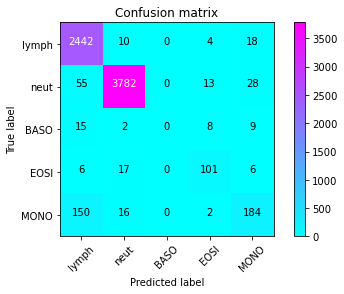

In [194]:
import itertools

from sklearn.metrics import plot_confusion_matrix




def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.cool):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
#Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test.argmax(axis=1), Y_pred.argmax(axis=1)) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = ["lymph","neut","BASO","EOSI","MONO"])#range(5)




In [195]:
import itertools

from sklearn.metrics import plot_confusion_matrix




def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.cool):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def con_mat(Threshold=1):
    predictions = model.predict_proba(X_test)*np.array([1,1,1,1,Threshold])
    predictions =predictions.argmax(axis=1)
    print(y_test[0])
    confusion_mtx = confusion_matrix(y_test.argmax(axis=1) , predictions)
    print(classification_report(y_test.argmax(axis=1), predictions , target_names=["lymph","neut","BASO","EOSI","MONO"]))
    plot_confusion_matrix(confusion_mtx, classes = ["lymph","neut","BASO","EOSI","MONO"])#range(5)


In [196]:

from ipywidgets import interactive, FloatSlider

interactive(lambda Threshold: con_mat(Threshold), Threshold=(0.0,10,.1))

interactive(children=(FloatSlider(value=5.0, description='Threshold', max=10.0), Output()), _dom_classes=('wid…

In [285]:
from sklearn.metrics import classification_report

classifiers = [tree.DecisionTreeClassifier(class_weight = 'balanced', max_depth = 1),  #0
               KNeighborsClassifier(7),                                                #1
               MLPClassifier(alpha=.1, max_iter=10000), #2
               AdaBoostClassifier(),#3
               SVC(gamma=2, C=1),#4
               GaussianNB(),#5
               RandomForestClassifier(max_depth=1, n_estimators=10, max_features=1)#6
               ]

clf= classifiers[2]


In [286]:
train_nan=np.isnan(X_train).sum()
if train_nan!=0: X_train[np.isnan(X_train)] = 0
    
test_nan=np.isnan(X_test).sum()
if test_nan!=0: X_test[np.isnan(X_test)] = 0


clf.fit(X_train, y_train)


#predictions=clf.predict(X_test)
predictions=clf.predict(X_test)


In [287]:
print(accuracy_score(y_test.argmax(axis=1), predictions.argmax(axis=1)))

0.9342124122115523


In [288]:
from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1) , target_names=["lymph","neut","BASO","EOSI","MONO"]))

              precision    recall  f1-score   support

       lymph       0.89      0.97      0.93      2583
        neut       0.99      0.98      0.98      3878
        BASO       0.10      0.03      0.05        34
        EOSI       0.70      0.73      0.71       130
        MONO       0.68      0.37      0.48       352

    accuracy                           0.93      6977
   macro avg       0.67      0.62      0.63      6977
weighted avg       0.93      0.93      0.93      6977



In [154]:
from sklearn.metrics import classification_report

classifiers = [tree.DecisionTreeClassifier(class_weight = 'balanced', max_depth = 1),  #0
               KNeighborsClassifier(7),                                                #1
               MLPClassifier(alpha=.1, max_iter=10000), #2
               AdaBoostClassifier(),#3
               SVC(gamma=2, C=1),#4
               GaussianNB(),#5
               RandomForestClassifier(max_depth=1, n_estimators=10, max_features=1)#6
               ]

cl=5
fe=16
clf= classifiers[2]

#x,y=alldata(cl,fe)
#X_train=x
#y_train=y







No cell detected...........
No cell detected...........
No cell detected...........


<ipython-input-123-30573234629b>:23: UserWarning: Input image is entirely zero, no valid convex hull. Returning empty image
  conv=morphology.convex_hull.convex_hull_image(im_part)
<ipython-input-123-30573234629b>:32: RuntimeWarning: invalid value encountered in true_divide
  return im_part.sum()/conv.sum()
<ipython-input-123-30573234629b>:36: RuntimeWarning: invalid value encountered in double_scalars
  return (pr**2)/(4*np.pi*im_part.sum())
<ipython-input-123-30573234629b>:39: UserWarning: Input image is entirely zero, no valid convex hull. Returning empty image
  conv=morphology.convex_hull.convex_hull_image(im_part)
<ipython-input-123-30573234629b>:40: RuntimeWarning: invalid value encountered in double_scalars
  return measure.perimeter(conv)/measure.perimeter(im_part)
<ipython-input-102-592d150322ec>:9: RuntimeWarning: invalid value encountered in double_scalars
  lst.append(measure.perimeter(nuc, neighbourhood=8)/n_sum)


In [ ]:
import pickle

lymph = [cv2.imread(f)[:,:,::-1] for f in glob.glob('./samples/PBC/LYMPH/*.jpg')]
neut =  [cv2.imread(f)[:,:,::-1] for f in glob.glob('./samples/PBC/NEUT/*.jpg')]
BASO =  [cv2.imread(f)[:,:,::-1] for f in glob.glob('./samples/PBC/BASO/*.jpg')]
EOSI =  [cv2.imread(f)[:,:,::-1] for f in glob.glob('./samples/PBC/EOSI/*.jpg')]
MONO =  [cv2.imread(f)[:,:,::-1] for f in glob.glob('./samples/PBC/MONO/*.jpg')]


classifiers = [tree.DecisionTreeClassifier(class_weight = 'balanced', max_depth = 1),  #0
               KNeighborsClassifier(7),                                                #1
               MLPClassifier(alpha=.1, max_iter=10000), #2
               AdaBoostClassifier(),#3
               SVC(gamma=2, C=1),#4
               GaussianNB(),#5
               RandomForestClassifier(max_depth=1, n_estimators=10, max_features=1)#6
               ]

cl=2
fe=15
clf= classifiers[2]

x,y=alldata(cl,fe)
X_train=x
y_train=y
clf.fit(X_train, y_train)
pickle.dump(clf, open('test.pkl', 'wb'))

predictions=clf.predict(X_train)
print(accuracy_score(y_train, predictions))



In [ ]:
# BCCD Dataset The labels (1- 5) represent neutrophil, lymphocyte, monocyte, eosinophil and basophil, respectively.

data1 = [cv2.imread(f)[:,:,::-1] for f in glob.glob('./samples/BCCD/Dataset1/*.bmp')]
data2 = [cv2.imread(f)[:,:,::-1] for f in glob.glob('./samples/BCCD/Dataset2/*.bmp')]


labels1 = pd.read_csv("./samples/BCCD/Class Labels of Dataset 1.csv") 
lst1=labels1['class label'].tolist()

labels2 = pd.read_csv("./samples/BCCD/Class Labels of Dataset 2.csv") 
lst2=labels2['class'].tolist()

ims=data1#data2+data1
lst=lst1# lst2+lst1

neut = [ims[i] for i,c in enumerate(lst) if c==1] #+neut
lymph = [ims[i] for i,c in enumerate(lst) if c==2] #+lymph
MONO =  [ims[i] for i,c in enumerate(lst) if c==3] #+MONO
EOSI = [ims[i] for i,c in enumerate(lst) if c==4] #+EOSI 
BASO =  [ims[i] for i,c in enumerate(lst) if c==5] #+BASO


x,y=alldata(cl,fe)


pickled_model = pickle.load(open('test.pkl', 'rb'))
predictions=pickled_model.predict(x)
accuracy_score(y, predictions)


In [ ]:
#mic_img = [cv2.imread(f)[:,:,::-1] for f in glob.glob('./samples/QSb MHS/QSb MHS/*.jpg')]; th=80
mic_img = [cv2.imread(f)[:,:,::-1] for f in glob.glob('./samples/Q2_#2/Q2_#2/*.png')]; th=30

plt.imshow(mic_img[2])
plt.show()

In [ ]:
img=mic_img[0].copy()
cv2.imwrite("wbc.png",img)
r=img.shape[0]
c=img.shape[1]
cn=0
ls_img=[]
for i in range(21,r-20):
    for j in range(21,c-20):
        if (int(img[i,j,2])-int(img[i,j,0]))>th: 
            im=img[i-20:i+20,j-20:j+20,:].copy()
            img[i-20:i+20,j-20:j+20,:]=0
            ls_img.append(im)
            cn=cn+1
            #plt.imshow(im)
            #plt.show()
cn

In [ ]:
import random
 
from matplotlib.pyplot import figure
cell_type=['LYMPH','NEUT','BASO','EOSI','MONO']
cell_type=['LYMPH','NEUT','MONO']

 
for im in ls_img :
    print( cell_type[pickled_model.predict([features(im, fe)])[0]])
    
    figure(figsize=(7, 7))

    plt.subplot(121)
    plt.imshow(im)
    plt.subplot(122)
    plt.imshow(deep_segment(im))
    plt.show()

In [ ]:

ff_model = keras.Sequential([
    keras.layers.InputLayer(input_shape=x.shape[1:]),
    keras.layers.Dense(units=5, activation="relu"),
    keras.layers.Dense(units=1),
])
ff_model.compile("sgd", loss="mean_absolute_error", metrics=["mean_squared_error"])
#ff_model.summary()


ff_model.fit(x, y, epochs=20) #Categorical Cross Entropy

In [ ]:
 

model = Sequential()
# Dense(64) is a fully-connected layer with 64 hidden units.
# The 'kernel_initializer' parameter allows us to set the distribution of the
# randomized weights that the layer is initialized with.
model.add(Dense(64, input_dim=X_train.shape[1], kernel_initializer="uniform"))
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Dense(64, kernel_initializer="uniform"))
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Dense(46, kernel_initializer="uniform"))
model.add(Activation('softmax'))

# Momentum: how much the weights are adjusted in response to the current gradient.
# Nesterov momentum: weights are adjusted by gradient descent, but gradient is also corrected
# after each step by examining the direction of the gradient at the new location.
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

model.fit(X_train, y_train,
          epochs=20,
          batch_size=16)
score = model.evaluate(X_test, y_test, batch_size=16)

In [ ]:
import random
 
from matplotlib.pyplot import figure
cell_type=['LYMPH','NEUT','BASO','EOSI','MONO']
cell_type=['LYMPH','NEUT','MONO']

#mHS = [cv2.imread(f)[:,:,::-1] for f in glob.glob('./samples/MHS/*/*.png') ]
mHS = [cv2.imread(f)[:,:,::-1] for f in glob.glob('./samples/From Cell images/*/*.png') ]
 

for im in mHS :# mHS:  #random.sample(pBC, 10) :random.sample(jX, 10) :
    print( cell_type[pickled_model.predict([features(im, fe)])[0]])
    
    figure(figsize=(7, 7))

    plt.subplot(121)
    plt.imshow(im)
    plt.subplot(122)
    plt.imshow(deep_segment(im))
    plt.show()

In [ ]:
...
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim=4, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)


In [ ]:
int(img[i,j,2])-int(img[i,j,0])




In [ ]:
import pickle

x,y=alldata(3,3)

pickled_model = pickle.load(open('KNeighborsClassifier_3classes.pkl', 'rb'))
predictions=pickled_model.predict(x)
accuracy_score(y, predictions)

In [ ]:
x=200
im=mic_img[0][1355+x:1370+x,980+x:1000+x,:]
plt.imshow(im)
plt.show()
mic_img[0][1558,1183,:]

In [ ]:
import pickle

x,y=alldata(3,2)

pickled_model = pickle.load(open('KNeighborsClassifier_3classes_2feat.pkl', 'rb'))
predictions=pickled_model.predict(x)
accuracy_score(y, predictions)

In [ ]:
import pickle

x,y=alldata(3,2)

pickled_model = pickle.load(open('MLPClassifier_3classes_2feat.pkl', 'rb'))
predictions=pickled_model.predict(x)
accuracy_score(y, predictions)

In [ ]:
import pickle

x,y=alldata(3,3)

pickled_model = pickle.load(open('MLPClassifier_3classes_3feat.pkl', 'rb'))
predictions=pickled_model.predict(x)
accuracy_score(y, predictions)

In [ ]:
import pickle

x,y=alldata(5,3)

pickled_model = pickle.load(open('MLPClassifier_5classes_3feat.pkl', 'rb'))
predictions=pickled_model.predict(x)
accuracy_score(y, predictions)

In [ ]:


import pickle

x,y=alldata(3,2)

pickled_model = pickle.load(open('AdaBoostClassifier_3classes_2feat.pkl', 'rb'))
predictions=pickled_model.predict(x)
accuracy_score(y, predictions)

In [ ]:
import pickle
x,y=alldata(3,1)
pickled_model = pickle.load(open('MLPClassifier_3classes_1feat.pkl', 'rb'))
predictions=pickled_model.predict(x)
accuracy_score(y, predictions)

In [ ]:
import pickle
x,y=alldata(5,3)
pickled_model = pickle.load(open('GaussianNB_5classes.pkl', 'rb'))
predictions=pickled_model.predict(x)
accuracy_score(y, predictions)

In [ ]:
import pickle
x,y=alldata(5,1)
pickled_model = pickle.load(open('RandomForestClassifier_3Classes_1Feat.pkl', 'rb'))
predictions=pickled_model.predict(x)
accuracy_score(y, predictions)

In [ ]:
clf=GaussianNB()
X_train=x
y_train=y1
clf.fit(X_train, y_train)
predictions=clf.predict(X_train)
accuracy_score(y_train, predictions)
import pickle
pickle.dump(clf, open('GaussianNB.pkl', 'wb'))

In [ ]:
pickled_model = pickle.load(open('GaussianNB.pkl', 'rb'))
predictions=pickled_model.predict(X_train)
accuracy_score(y_train, predictions)



In [ ]:
import random
 
from matplotlib.pyplot import figure
cell_type=['LYMPH','NEUT','BASO','EOSI','MONO']


#mHS = [cv2.imread(f)[:,:,::-1] for f in glob.glob('./samples/MHS/*/*.png') ]
mHS = [cv2.imread(f)[:,:,::-1] for f in glob.glob('./samples/From Cell images/*/*.png') ]


for im in mHS:# mHS:  #random.sample(pBC, 10) :random.sample(jX, 10) :
    mask=mask_cell(im)
    print(cell_type[ pickled_model.predict([obj.describe(mask)])[0]])
    
    figure(figsize=(15, 15))

    plt.subplot(141)
    plt.imshow(im)
    plt.subplot(142)
    plt.imshow(deep_segment(im))
    plt.subplot(143)
    plt.imshow(get_nuc_and_cyt(deep_segment(im))[0])
    plt.subplot(144)
    plt.imshow(mask)
    plt.show()